In [1]:
import tensorflow 
import numpy as np
import pandas as pd
import pickle
import cv2
import keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, InputLayer, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops
ops.get_default_graph()

Using TensorFlow backend.


In [2]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil

#from skimage.io import imread
#from skimage.transform import resize
# Don't use skimage, it sucks (Can't read all iamges). Cv2 is better. 

In [3]:
from numpy import loadtxt
from tensorflow.keras.models import load_model

In [4]:
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

config = tensorflow.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tensorflow.compat.v1.Session(config=config) 
tensorflow.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8112762806892072836
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10332352581331535358
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3155296256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7835212910993553383
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14036121750567399899
physical_device_desc: "device: XLA_GPU

In [5]:
EPOCHS = 100
INIT_LR = 1e-4
BS = 16
default_image_size = tuple((299, 299))
image_size = 0
directory_root = '../../../../Datasets/plant-seedlings-classification/train/' # Can be deleted
width=299
height=299
depth=3

In [6]:
iv3_model = load_model('InceptionV3_model1_12_categories_4750_plant_seedlings.h5')


In [7]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
label_names = np.load('label_names.npy')

In [8]:
# modified generator for cv2 resize error.

class My_Custom_Generator(tensorflow.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    xyz = []
    pqr = []
    
    for i,file_name in enumerate(batch_x):
        try:
            image = cv2.imread('../../../../Datasets/plant-seedlings-classification/train_all_images/' + str(file_name))
            if image is not None :
                image = cv2.resize(image, default_image_size)   
                xyz.append(img_to_array(image))
                pqr.append(batch_y[i])
        except Exception as e:
            print(f"Error : {e}")
            return None
    
    return np.array(xyz)/255.0, np.array(pqr)

In [9]:
iv3_model.evaluate(My_Custom_Generator(x_test, y_test, BS))

30/30 [==============================] - 28s 921ms/step - loss: 0.3165 - accuracy: 0.9579


[0.3164647469432734, 0.95789474]

In [10]:
test_predictions = iv3_model.predict_generator(My_Custom_Generator(x_test, y_test, BS))

In [11]:
#test_predictions.shape

In [12]:
# To remove faulty label from y_test corresponding to x_test
pqr = []
xyz = []
for i,file_name in enumerate(x_test):
    try:
        image = cv2.imread('../../../../Datasets/plant-seedlings-classification/train_all_images/' + str(file_name))

        if image is not None: 
            pqr.append(y_test[i])
            xyz.append(x_test[i])
    except Exception as e:
            print(f"Error : {e}")
pqr = np.array(pqr)
xyz = np.array(xyz)

In [13]:
#pqr.shape

In [14]:
predictions = pd.DataFrame(test_predictions)
predictions = list(predictions.idxmax(axis=1))
predictions = to_categorical(predictions)
test_labels = list(pqr)
predictions = np.argmax(predictions, axis=1)
predictions = np.array(predictions)
test_labels = np.argmax(test_labels, axis=1)
test_labels = np.array(test_labels)

# evaluate model performance
import model_evaluation_utils as meu
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.9579
Precision: 0.9592
Recall: 0.9579
F1 Score: 0.9579


In [15]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(range(0,15)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.90      0.95        31
           2       0.99      1.00      0.99        71
           3       0.98      1.00      0.99        43
           4       1.00      0.87      0.93        15
           5       1.00      0.92      0.96        24
           6       0.96      0.96      0.96        52
           7       0.92      0.97      0.95        72
           8       0.98      1.00      0.99        45
           9       0.98      0.98      0.98        48
          10       1.00      0.89      0.94        18
          11       0.77      0.79      0.78        29
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

   micro avg       0.96      0.96      0.96       475
   macro avg       0.77      0.75      0.76       475
weighted avg       0.96   

/home/mayank/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mayank/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
#print(test_labels[0:500] == predictions[0:500])

In [17]:
#label_names

In [18]:
label_names = label_names.flatten()

In [19]:
#label_names

In [20]:
label_names = np.ndarray.tolist(label_names)
#label_names

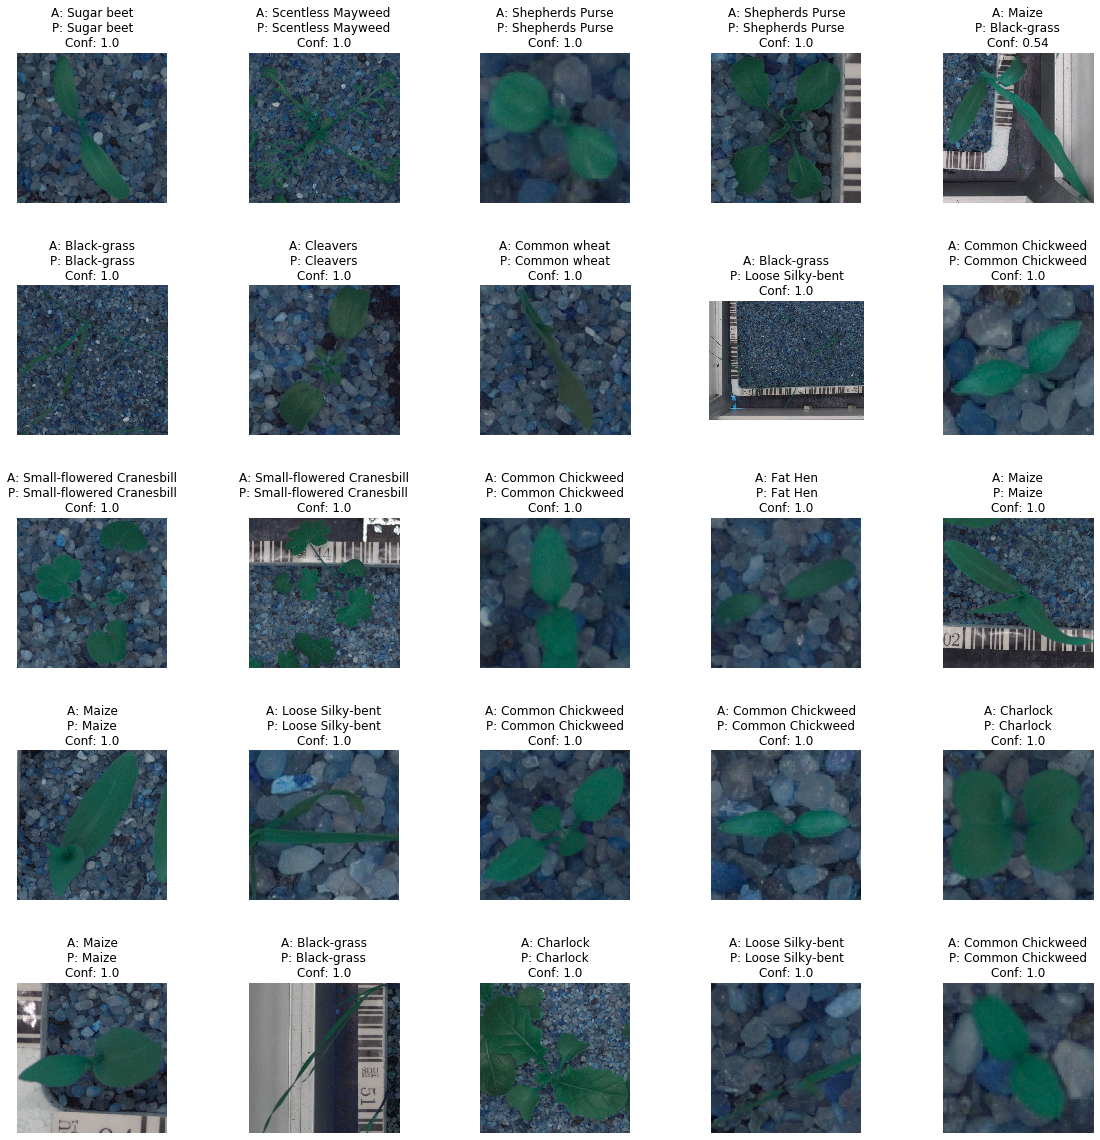

In [21]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

labels_ohe_names = pd.get_dummies(label_names, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
label_dict = dict(enumerate(labels_ohe_names.columns.values))

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = label_names[(test_labels[img_idx])]
        prediction = test_predictions[img_idx]
        label_idx = np.argmax(prediction)
        predicted_label = label_names[label_idx]
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('A: '+actual_label+'\nP: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(cv2.imread('../../../../Datasets/plant-seedlings-classification/train_all_images/' + xyz[img_idx]))
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55) 
f.savefig('post_process.png', bbox_inches='tight')

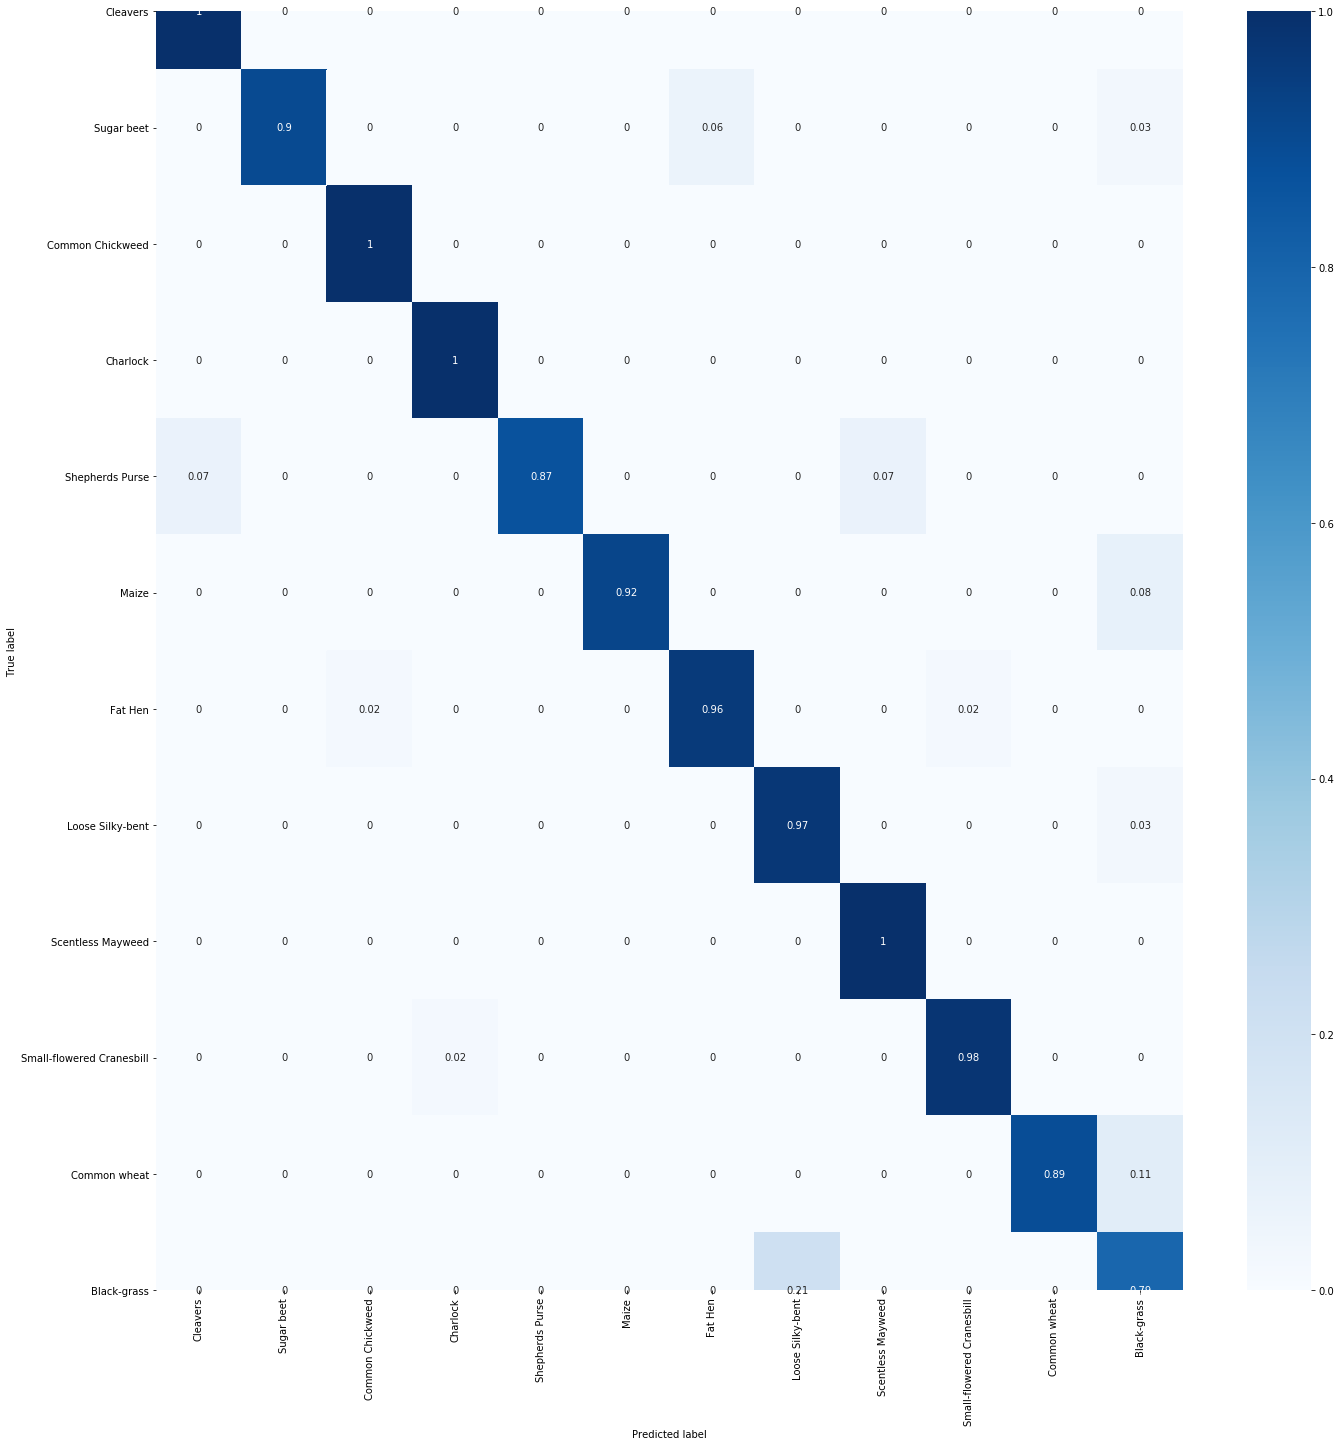

In [22]:
# Plotting Confusion Matrix
import seaborn as sns
con_mat = tensorflow.math.confusion_matrix(labels=test_labels, predictions=predictions).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = label_names, 
                     columns = label_names)

figure = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
figure.savefig('confusion_matrix.png', bbox_inches='tight')

In [23]:
label_dict

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}